# **CMPE 297- Advanced Deep Learning**
**Assignment 1 Part A**

Implementing SimCLR in Pytorch

**Acknowledgement:** https://medium.com/analytics-vidhya/understanding-simclr-a-simple-framework-for-contrastive-learning-of-visual-representations-d544a9003f3c

#Import necessary libraries

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import torch.nn as nn
from collections import OrderedDict, namedtuple
from torchvision.models import resnet18
import torchvision.transforms as transforms

#Download the data

In [ ]:
!gdown https://drive.google.com/uc?id=1x3BSoqoe76FcWdbagLj6Mx6_2EAJ982g

Downloading...
From: https://drive.google.com/uc?id=1x3BSoqoe76FcWdbagLj6Mx6_2EAJ982g
To: /content/milli_imagenet.zip
92.9MB [00:01, 76.3MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('milli_imagenet.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/')

#Implement augmented image pairs in the dataset

In [ ]:

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, args):
        self.args = args
        with open(os.path.join(args.datapath, "train","names.txt")) as f:
            self.filenames = f.read().split('\n')
 
    def __len__(self):
        return len(self.filenames)

    def tensorify(self, img):
        return transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(
            transforms.ToTensor()(img)
            )
    
    def get_color_distortion(self, s=1.0):
        color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        rnd_color_jitter =  transforms.RandomApply([color_jitter], p=0.8)
        rnd_gray =  transforms.RandomGrayscale(p=0.2)
        color_distort =  transforms.Compose([rnd_color_jitter, rnd_gray])
        return color_distort

    def augmented_image(self, img):
        return self.get_color_distortion(1)(
            transforms.RandomResizedCrop(224)(img)
            )    

    def __getitem__(self, idx):
        img = transforms.Resize((224, 224))(
                                Image.open(os.path.join(args.datapath, 'train', self.filenames[idx])).convert('RGB')
                            )
        return {
        'image1':self.tensorify(
            self.augmented_image(img)
            ), 
        'image2': self.tensorify(
            self.augmented_image(img)
            )
        }

#Define ResNet model

In [ ]:
def get_model(args):
    resnet = resnet18(pretrained=False)

    head = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(resnet.fc.in_features, 100)),
        ('added_relu1', nn.ReLU(inplace=True)),
        ('fc2', nn.Linear(100, 100)),
        ('added_relu2', nn.ReLU(inplace=True)),
        ('fc3', nn.Linear(100, 100))
    ]))

    resnet.fc = head

    if args.multiple_gpus:
        resnet = nn.DataParallel(resnet)

    resnet.to(args.device)

    return resnet

#Define loss function

In [ ]:
tau = 0.05

def loss_function(a, b):
    a_norm = torch.norm(a, dim=1).reshape(-1, 1)
    a_cap = torch.div(a, a_norm)
    b_norm = torch.norm(b, dim=1).reshape(-1, 1)
    b_cap = torch.div(b, b_norm)
    a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
    sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim, tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators, denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

def plot_losses(arr, legend_name):
    plt.figure(figsize=(10, 10))
    sns.set_style('darkgrid')
    plt.plot(arr)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.show()

#Define SimCLR training loop

In [ ]:
class SimCLR:
    def __init__(self, model, optimizer, dataloaders, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.loss_fn = loss_fn

    def train(self, args, num_epochs, log_interval):
        batch_losses = []

        self.model.train()
    
        # run a for loop for num_epochs
        for epoch in range(num_epochs):

            # run a for loop for each batch
            for step, batch in enumerate(self.dataloaders['train']):
                # zero out grads
                self.optimizer.zero_grad()

                x1 = batch['image1'].to(args.device)
                x2 = batch['image2'].to(args.device)

                # get their outputs
                y1 = self.model(x1)
                y2 = self.model(x2)

                # get loss value
                loss = self.loss_fn(y1, y2)

                batch_losses.append(loss.cpu().data.item())

                # perform backprop on loss value to get gradient values
                loss.backward()

                # run the optimizer
                self.optimizer.step()
                
                if step % log_interval == 0:
                    print(f'Epoch: {epoch} / {num_epochs} Step: {step} Loss: {loss.item()}')
                
                if step >= 5:
                  break
            
        plot_losses(batch_losses, 'Training Losses')

#Run SimCLR Training

1250 images found for training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 / 5 Step: 0 Loss: 2.7267258167266846
Epoch: 0 / 5 Step: 5 Loss: 2.676352024078369
Epoch: 1 / 5 Step: 0 Loss: 2.625755786895752
Epoch: 1 / 5 Step: 5 Loss: 2.6106362342834473
Epoch: 2 / 5 Step: 0 Loss: 2.740912675857544
Epoch: 2 / 5 Step: 5 Loss: 2.5318763256073
Epoch: 3 / 5 Step: 0 Loss: 2.663151264190674
Epoch: 3 / 5 Step: 5 Loss: 2.9430150985717773
Epoch: 4 / 5 Step: 0 Loss: 2.8283162117004395
Epoch: 4 / 5 Step: 5 Loss: 2.635739326477051


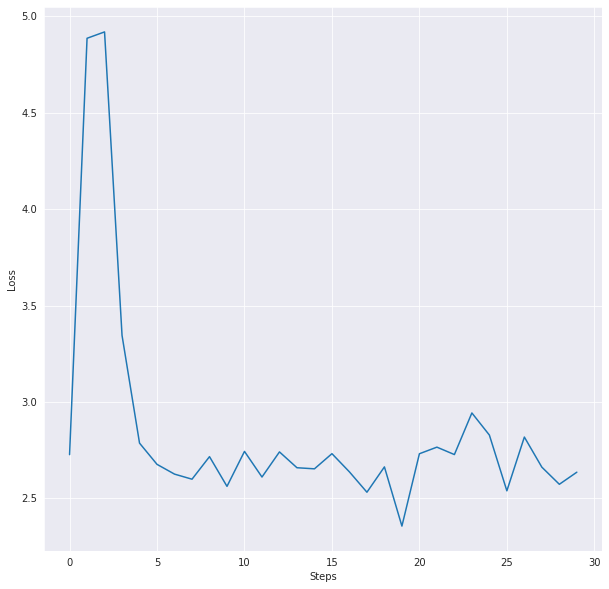

In [ ]:
args = {
    'datapath': '/content/milli_imagenet',
    'cuda': False,
    'batch_size': 8,
    'num_workers': 2,
    'multiple_gpus': False,
}
args['device'] = torch.device('cuda' if args['cuda'] else 'cpu')
args = namedtuple('Args', args.keys())(*args.values())

model = get_model(args)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001, 
    weight_decay=1e-4
    )

dataloaders = {}
ds = TrainDataset(args)
print(f'{len(ds)} images found for training')

dataloaders['train'] = torch.utils.data.DataLoader(
    ds, 
    batch_size=args.batch_size, 
    shuffle=True, 
    num_workers=args.num_workers
    )

loss_fn = loss_function
simclrobj = SimCLR(model, optimizer, dataloaders, loss_fn)
simclrobj.train(args, 5, 5)
